<a href="https://colab.research.google.com/github/Chay16/dataflowr-PlutonAI/blob/master/05_collaborative_filtering_PlutonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative filtering
-----

In this example, we'll build a quick explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content.

We'll use an approach first made popular by the [Netflix prize](http://www.netflixprize.com/) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf). 

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

![collaborative filtering](http://ampcamp.berkeley.edu/big-data-mini-course/img/matrix_factorization.png)
source:[ampcamp.berkeley](http://ampcamp.berkeley.edu/big-data-mini-course/movie-recommendation-with-mllib.html)

## 1. Preparations

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line needs to be modified if not on colab:
data_folder = '/content/'

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = op.join(data_folder,ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = op.join(data_folder,'ml-100k')

We start with importing a famous dataset, the [Movielens 100k dataset](https://grouplens.org/datasets/movielens/100k/). It contains 100,000 ratings (between 1 and 5) given to 1682 movies by 943 users:

In [0]:
if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall(data_folder)

Other datasets, see: [Movielens](https://grouplens.org/datasets/movielens/)

## 2. Data analysis and formating

[Python Data Analysis Library](http://pandas.pydata.org/)

In [3]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "ratings", "timestamp"])
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Let's check out a few macro-stats of our dataset

In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_100K_FOLDER, 'u.item'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('|')[0])
        list_movies_names.append(line.split('|')[1])
        
movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)), 
               columns =['item_id', 'item_name']) 
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [0]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)

In [6]:
all_ratings = all_ratings.merge(movies_names,on='item_id')
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
#number of entries
len(all_ratings)

100000

In [8]:
all_ratings['ratings'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: ratings, dtype: float64

In [9]:
# number of unique rating values
len(all_ratings['ratings'].unique())

5

In [10]:
all_ratings['user_id'].describe()

count    100000.00000
mean        462.48475
std         266.61442
min           1.00000
25%         254.00000
50%         447.00000
75%         682.00000
max         943.00000
Name: user_id, dtype: float64

In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

943


In [12]:
all_ratings['item_id'].describe()

count    100000.000000
mean        425.530130
std         330.798356
min           1.000000
25%         175.000000
50%         322.000000
75%         631.000000
max        1682.000000
Name: item_id, dtype: float64

In [13]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

1682


In [0]:
all_ratings['item_id'] = all_ratings['item_id'].apply(lambda x :x-1)
all_ratings['user_id'] = all_ratings['user_id'].apply(lambda x :x-1)

In [0]:
movies_names['item_id']=movies_names['item_id'].apply(lambda x: x-1)

In [0]:
movies_names=movies_names.set_index('item_id')

In [17]:
movies_names.head()

,item_name
item_id,
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


For spliting the data into _train_ and _test_ we'll be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [0]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=42)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [19]:
len(user_id_train)

80000

In [20]:
len(user_id_train.unique())

943

In [21]:
len(item_id_train.unique())

1656

We see that all the movies are not rated in the train set.

In [22]:
movies_not_train = (set(all_ratings['item_id']) -set(item_id_train))
for m in movies_not_train:
    print(m,movies_names.loc[m]['item_name'])

1155 Cyclo (1995)
1541 Scarlet Letter, The (1926)
1561 Eye of Vichy, The (Oeil de Vichy, L') (1993)
1564 Daens (1992)
1565 Man from Down Under, The (1943)
1567 Vermont Is For Lovers (1992)
1570 Touki Bouki (Journey of the Hyena) (1973)
1446 Century (1993)
1451 Lady of Burlesque (1943)
1452 Angel on My Shoulder (1946)
1582 Invitation, The (Zaproszenie) (1986)
1328 Low Life, The (1994)
1457 Damsel in Distress, A (1937)
1589 To Have, or Not (1995)
1338 Stefano Quantestorie (1993)
1598 Someone Else's America (1995)
1471 Visitors, The (Visiteurs, Les) (1993)
1603 He Walked by Night (1948)
1613 Reluctant Debutante, The (1958)
1492 Modern Affair, A (1995)
856 Paris Was a Woman (1995)
1625 Nobody Loves Me (Keiner liebt mich) (1994)
1640 Dadetown (1995)
1519 Fear, The (1995)
1524 Object of My Affection, The (1998)
1658 Getting Away With Murder (1996)


In [23]:
user_id_train.iloc[:5]

75220    434
48955    338
44966    847
13568    751
92727    177
Name: user_id, dtype: int64

In [24]:
item_id_train.iloc[:5]

75220    423
48955    210
44966    185
13568    337
92727     75
Name: item_id, dtype: int64

In [25]:
rating_train.iloc[:5]

75220    1
48955    5
44966    5
13568    3
92727    3
Name: ratings, dtype: int64

## 3. The model

We can feed our dataset to the `FactorizationModel` class - a sklearn-like object that allows us to train and evaluate the explicit factorization models.

Internally, the model uses the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.

In [0]:
import torch.nn as nn
import torch

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's generate [Embeddings](http://pytorch.org/docs/master/nn.html#embedding) for the users, _i.e._ a fixed-sized vector describing the user

In [28]:
embedding_dim = 3
embedding_user = nn.Embedding(total_user_id, embedding_dim)
input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
embedding_user(input)

tensor([[[ 1.8053e+00, -9.1979e-01, -2.0192e-01],
         [-1.0031e-03,  1.2252e+00, -3.9910e-01],
         [-4.5317e-01, -9.0910e-02,  2.6351e-01],
         [ 5.0272e-01,  6.1570e-02, -1.8178e+00]],

        [[-4.5317e-01, -9.0910e-02,  2.6351e-01],
         [-3.8448e-01,  4.3544e-02,  9.5234e-01],
         [-1.0031e-03,  1.2252e+00, -3.9910e-01],
         [ 1.6759e-01,  3.4751e-01, -2.8921e-01]]],
       grad_fn=<EmbeddingBackward>)

We will use some custom embeddings and dataloader

In [0]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the emedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """
        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """
        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [0]:
class DotModel(nn.Module):
    
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):
        
        super(DotModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)
                
        
    def forward(self, user_ids, item_ids):
        
        #
        # your code here
        x = (self.user_embeddings(user_ids) * self.item_embeddings(item_ids)).sum(1)
        #
        return x + self.user_biases(user_ids).squeeze() + self.item_biases(item_ids).squeeze()


In [0]:
net = DotModel(total_user_id,total_item_id).to(device)

Now test your network on a small batch.

In [0]:
batch_users_np = user_id_train.values[:5].astype(np.int32)
batch_items_np = item_id_train.values[:5].astype(np.int32)
batch_ratings_np = rating_train[:5].values.astype(np.float32)
batch_users_tensor = torch.LongTensor(batch_users_np).to(device)
batch_items_tensor = torch.LongTensor(batch_items_np).to(device)
batch_ratings_tensor = torch.tensor(batch_ratings_np).to(device)

In [0]:
predictions = net(batch_users_tensor,batch_items_tensor)

In [34]:
predictions

tensor([-0.0051, -0.0013,  0.0027,  0.0037,  0.0004], device='cuda:0',
       grad_fn=<AddBackward0>)

We will use MSE loss defined below:

In [0]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [0]:
loss_fn = regression_loss
loss = loss_fn(predictions, batch_ratings_tensor)

In [37]:
loss

tensor(13.7943, device='cuda:0', grad_fn=<MeanBackward0>)

Check that your network is learning by overfitting your network on this small batch (you should reach a loss below 0.5 in the cell below).

In [38]:
net = DotModel(total_user_id,total_item_id).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.1)
for e in range(15):
    #
    # your code here
    outputs = net(batch_users_tensor,batch_items_tensor)
    optimizer.zero_grad()
    loss = loss_fn(outputs, batch_ratings_tensor)
    loss.backward()
    optimizer.step()
    print("Epoch {}/15 - Loss : {}".format(e+1,loss.data.item()/len(batch_users_tensor)))
    #

Epoch 1/15 - Loss : 2.7595367431640625
Epoch 2/15 - Loss : 2.2859338760375976
Epoch 3/15 - Loss : 1.4734759330749512
Epoch 4/15 - Loss : 0.7312576293945312
Epoch 5/15 - Loss : 0.22311947345733643
Epoch 6/15 - Loss : 0.16508268117904662
Epoch 7/15 - Loss : 0.38782851696014403
Epoch 8/15 - Loss : 0.4833329200744629
Epoch 9/15 - Loss : 0.3370612859725952
Epoch 10/15 - Loss : 0.177644944190979
Epoch 11/15 - Loss : 0.0841037929058075
Epoch 12/15 - Loss : 0.11739931106567383
Epoch 13/15 - Loss : 0.19616016149520873
Epoch 14/15 - Loss : 0.20706658363342284
Epoch 15/15 - Loss : 0.15180271863937378


In [0]:
def shuffle(*arrays):

    random_state = np.random.RandomState()
    shuffle_indices = np.arange(len(arrays[0]))
    random_state.shuffle(shuffle_indices)

    if len(arrays) == 1:
        return arrays[0][shuffle_indices]
    else:
        return tuple(x[shuffle_indices] for x in arrays)

In [0]:
def minibatch(batch_size, *tensors):

    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)



In [0]:
import imp
import numpy as np

import torch.optim as optim

class FactorizationModel(object):
    
    def __init__(self, embedding_dim=32, n_iter=10, batch_size=256, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):
        
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()
             
        
    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)
        
        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )
        
        self._loss_func = regression_loss
    
    @property
    def _initialized(self):
        return self._optimizer is not None
    
    
    def fit(self, user_ids, item_ids, ratings, verbose=True):
        
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)
        
        if not self._initialized:
            self._initialize()
            
        for epoch_num in range(self._n_iter):
            users, items, ratingss = shuffle(user_ids,
                                            item_ids,
                                            ratings)

            user_ids_tensor = torch.from_numpy(users).to(self._device)
            item_ids_tensor = torch.from_numpy(items).to(self._device)
            ratings_tensor = torch.from_numpy(ratingss).to(self._device)
            epoch_loss = 0.0

            for (minibatch_num,
                 (batch_user,
                  batch_item,
                  batch_rating)) in enumerate(minibatch(self._batch_size,
                                                         user_ids_tensor,
                                                         item_ids_tensor,
                                                         ratings_tensor)):
                
                
                # beging to be completed
                predictions = self._net(batch_user, batch_item)
                #
                self._optimizer.zero_grad()
                loss = self._loss_func(predictions, batch_rating)
                epoch_loss += loss.data.item() 
                loss.backward()
                self._optimizer.step()
                #
                #
                # end to be completed
            
            epoch_loss = epoch_loss / (minibatch_num + 1)
            
            if verbose:
                print('Epoch {}: loss_train {}'.format(epoch_num+1, epoch_loss))
        
            if np.isnan(epoch_loss) or epoch_loss == 0.0:
                raise ValueError('Degenerate epoch loss: {}'
                                 .format(epoch_loss))
    
    
    def test(self,user_ids, item_ids, ratings):
        self._net.train(False)
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)
        
        user_ids_tensor = torch.from_numpy(user_ids).to(self._device)
        item_ids_tensor = torch.from_numpy(item_ids).to(self._device)
        ratings_tensor = torch.from_numpy(ratings).to(self._device)
               
        predictions = self._net(user_ids_tensor, item_ids_tensor)
        
        loss = self._loss_func(ratings_tensor, predictions)
        return loss.data.item()

    def predict(self, user_ids, item_ids):
        self._net.train(False)
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)
        
        user_ids_tensor = torch.from_numpy(user_ids).to(self._device)
        item_ids_tensor = torch.from_numpy(item_ids).to(self._device)
               
        predictions = self._net(user_ids_tensor, item_ids_tensor)

        return predictions.data  

In [0]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=5,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [0]:
user_ids_train_np = user_id_train.values.astype(np.int32)
item_ids_train_np = item_id_train.values.astype(np.int32)
ratings_train_np = rating_train.values.astype(np.float32)
user_ids_test_np = user_id_test.values.astype(np.int64)
item_ids_test_np = item_id_test.values.astype(np.int64)
ratings_test_np = rating_test.values.astype(np.float32)

In [44]:
model.fit(user_ids_train_np, item_ids_train_np, ratings_train_np)

Epoch 1: loss_train 13.306593291367157
Epoch 2: loss_train 11.627862362921993
Epoch 3: loss_train 6.590889813024787
Epoch 4: loss_train 2.4039175208610826
Epoch 5: loss_train 1.3241434670701813


In [45]:
model.test(user_ids_test_np, item_ids_test_np, ratings_test_np  )

1.2009456157684326

In [46]:
print(model._net)

DotModel(
  (user_embeddings): ScaledEmbedding(943, 50)
  (item_embeddings): ScaledEmbedding(1682, 50)
  (user_biases): ZeroEmbedding(943, 1)
  (item_biases): ZeroEmbedding(1682, 1)
)


In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict(user_ids_test_np, item_ids_test_np)
print("Final test RMSE: %0.3f" % np.sqrt(mean_squared_error(test_preds.cpu(), ratings_test_np)))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds.cpu(), ratings_test_np))

Final test RMSE: 1.096
Final test MAE: 0.866


You can compare with [Surprise](https://github.com/NicolasHug/Surprise)

## 4. Best and worst movies

Getting the name of the movies (there must be a better way, please provide alternate solutions!)

In [48]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_100K_FOLDER, 'u.item'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('|')[0])
        list_movies_names.append(line.split('|')[1])
        
movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)), 
               columns =['item_id', 'item_name']) 
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [0]:
item_bias_np = model._net.item_biases.weight.data.cpu().numpy()

In [0]:
movies_names['biases'] = pd.Series(item_bias_np.T[0], index=movies_names.index)

In [51]:
movies_names.head()

,item_id,item_name,biases
0,1,Toy Story (1995),0.217501
1,2,GoldenEye (1995),0.169648
2,3,Four Rooms (1995),0.163964
3,4,Get Shorty (1995),0.184660
4,5,Copycat (1995),0.176392


In [52]:
movies_names.shape

(1682, 3)

In [53]:
indices_item_train = np.sort(item_id_train.unique())
movies_names = movies_names.loc[indices_item_train]
movies_names.shape

(1656, 3)

In [0]:
movies_names = movies_names.sort_values(ascending=False,by=['biases'])

Best movies

In [55]:
movies_names.head(10)

,item_id,item_name,biases
312,313,Titanic (1997),0.248345
268,269,"Full Monty, The (1997)",0.235461
301,302,L.A. Confidential (1997),0.234561
271,272,Good Will Hunting (1997),0.233097
49,50,Star Wars (1977),0.229521
339,340,Boogie Nights (1997),0.228147
257,258,Contact (1997),0.227830
285,286,"English Patient, The (1996)",0.227516
306,307,"Devil's Advocate, The (1997)",0.224558
299,300,Air Force One (1997),0.223448


Worse movies

In [56]:
movies_names.tail(10)

,item_id,item_name,biases
851,852,"Bloody Child, The (1996)",0.030022
1308,1309,"Very Natural Thing, A (1974)",0.029781
1668,1669,MURDER and murder (1996),0.029689
1620,1621,Butterfly Kiss (1995),0.029203
1665,1666,Ripe (1996),0.029165
1547,1548,The Courtyard (1995),0.029099
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),0.028949
829,830,Power 98 (1995),0.028943
1303,1304,New York Cop (1996),0.028900
1485,1486,Girl in the Cadillac (1995),0.028724


## 5. PCA

In [57]:
item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()
item_emb_np.shape

(1682, 50)

In [0]:
from sklearn.decomposition import PCA
from operator import itemgetter

pca = PCA(n_components=3)
latent_fac = pca.fit_transform(item_emb_np)

In [0]:
movie_comp = [(f, i) for f,i in zip(latent_fac[:,1], list_movies_names)]

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.48136267, "Devil's Own, The (1997)"),
 (0.47676995, 'Air Force One (1997)'),
 (0.46139196, "Dante's Peak (1997)"),
 (0.43272406, 'Kiss the Girls (1997)'),
 (0.43221238, 'Conspiracy Theory (1997)'),
 (0.41800764, "Devil's Advocate, The (1997)"),
 (0.41602927, 'Seven Years in Tibet (1997)'),
 (0.4084312, 'Murder at 1600 (1997)'),
 (0.40793452, 'Peacemaker, The (1997)'),
 (0.3997503, 'G.I. Jane (1997)')]

In [61]:
sorted(movie_comp, key=itemgetter(0), reverse=False)[:10]

[(-0.18040213, 'Dial M for Murder (1954)'),
 (-0.17152599,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (-0.1621221, 'Farewell to Arms, A (1932)'),
 (-0.16135183, 'Duck Soup (1933)'),
 (-0.16056594, 'Raising Arizona (1987)'),
 (-0.15550336, 'Chinatown (1974)'),
 (-0.15366556, 'Queen Margot (Reine Margot, La) (1994)'),
 (-0.15217753, 'Ran (1985)'),
 (-0.15170382, 'To Catch a Thief (1955)'),
 (-0.15075427, 'Cat on a Hot Tin Roof (1958)')]

In [62]:
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
most_rated_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

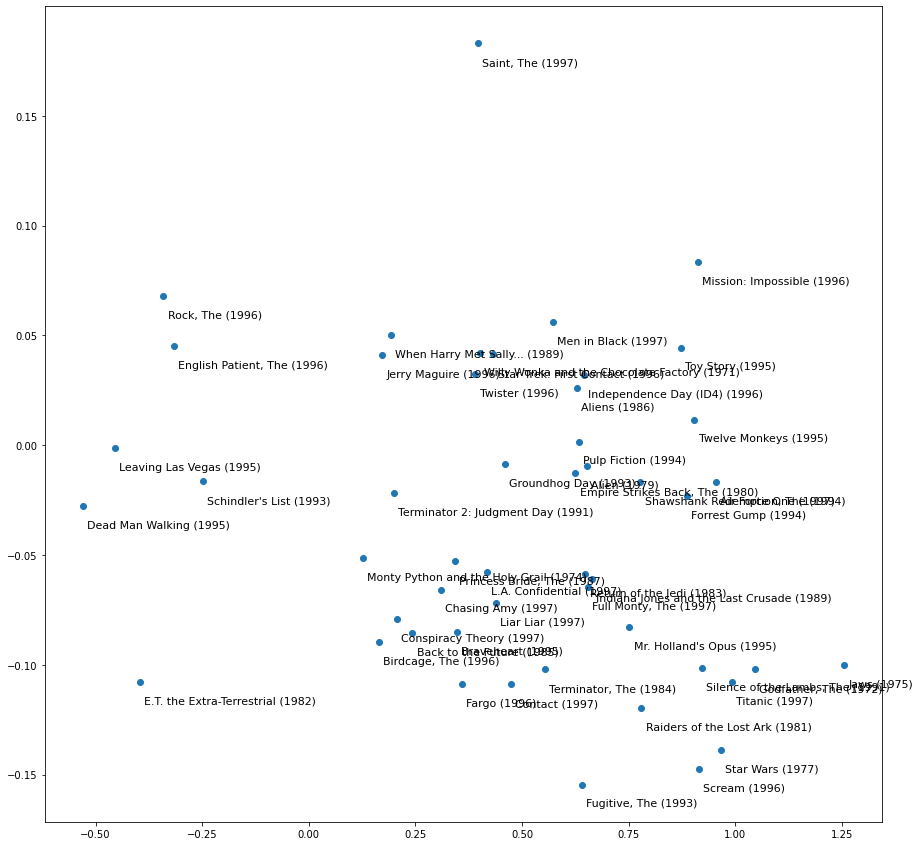

In [63]:
idxs = range(50)
txt_movies_names = most_rated_movies[:len(idxs)]
X = latent_fac[idxs,0]
Y = latent_fac[idxs,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

## 6. SPOTLIGHT

The code written above is a simplified version of [SPOTLIGHT](https://github.com/maciejkula/spotlight)

Once you installed it with: `conda install -c maciejkula -c pytorch spotlight=0.1.5`, you can compare the results...

Spotlight Performances on MovieLens dataset :
- Train RMSE 0.907
- Test RMSE 0.946